# Basic imports


In [1]:
%reload_ext autoreload
%autoreload 2
import spikeinterface as si
import spikeinterface.extractors as se 
import spikeinterface.preprocessing as spre
import spikeinterface.sorters as ss
import spikeinterface.postprocessing as spost
import spikeinterface.qualitymetrics as sqm
import spikeinterface.comparison as sc
import spikeinterface.exporters as sexp
import spikeinterface.curation as scur
import spikeinterface.widgets as sw
from spikeinterface.exporters import export_to_phy
print(f"SpikeInterface version: {si.__version__}")
import probeinterface as pi
from probeinterface import Probe, ProbeGroup
from probeinterface.plotting import plot_probe, plot_probegroup 

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from pathlib import Path
import glob
import os, sys
import pickle, h5py
import re
from datetime import datetime
import shutil
from joblib import Parallel, delayed

from scipy.io import loadmat
from utils.data_io import select_folder, extract_datetime, create_channel_map, get_sampling_rate
# Note: If importing fails, please restart the kernel to refresh the module.

n_cpus = os.cpu_count()
n_jobs = n_cpus - 6
job_kwargs = dict(n_jobs=n_jobs, progress_bar=True)

SpikeInterface version: 0.103.2


# Basepath setup

In [2]:
# Path setup
basepath = "/local/workdir/ys2375/data/ayadataB1/data/hpc_ctx_project/HP04/day_32_20240430"
# basepath = select_folder(initial_drive="V:\\")
base_dir = Path(basepath)

# Output directory
outputDir = Path(os.getcwd() + "/sorting_temp") / base_dir.name
outputDir.mkdir(parents=True, exist_ok=True)

# XML: Copy amplifier.xml from parent to base_dir as [dirname].xml
xmlPath = base_dir / f"{base_dir.name}.xml"
# src_xml = base_dir.parent / "amplifier.xml"
# if src_xml.exists() and not xmlPath.exists():
#     shutil.copy2(src_xml, xmlPath)

# Find recording files 
# dataPath = sorted(list(base_dir.glob("*.dat")))
dataPath = sorted(glob.glob(str(base_dir / "*/amplifier.dat")), key=extract_datetime)

print(f"XML path: {xmlPath}")
print(f"Recording files paths: {str(dataPath)}")
print(f"Output directory: {outputDir}")

XML path: /local/workdir/ys2375/data/ayadataB1/data/hpc_ctx_project/HP04/day_32_20240430/day_32_20240430.xml
Recording files paths: ['/local/workdir/ys2375/data/ayadataB1/data/hpc_ctx_project/HP04/day_32_20240430/probe_240430_102422/amplifier.dat', '/local/workdir/ys2375/data/ayadataB1/data/hpc_ctx_project/HP04/day_32_20240430/presleep_240430_103233/amplifier.dat', '/local/workdir/ys2375/data/ayadataB1/data/hpc_ctx_project/HP04/day_32_20240430/cheeseboard_240430_123200/amplifier.dat', '/local/workdir/ys2375/data/ayadataB1/data/hpc_ctx_project/HP04/day_32_20240430/cheeseboard_2_240430_130126/amplifier.dat', '/local/workdir/ys2375/data/ayadataB1/data/hpc_ctx_project/HP04/day_32_20240430/postsleep_240430_131552/amplifier.dat']
Output directory: /local/workdir/ys2375/PreprocessPipeline/sorting_temp/day_32_20240430


(<matplotlib.collections.PolyCollection at 0x7f6ba34ef390>, None)

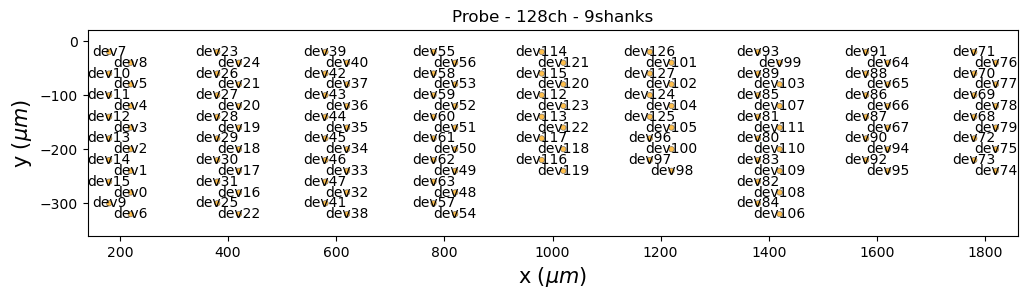

In [3]:
chanMapPath = glob.glob(basepath + '/chanMap.mat')[0]
chanMapmat_correct = loadmat(chanMapPath)
x = chanMapmat_correct['xcoords'].flatten()
y = chanMapmat_correct['ycoords'].flatten()
coords = np.column_stack((x, y))
shank_ids = chanMapmat_correct['kcoords'].flatten()
device_ch_inds = chanMapmat_correct['chanMap'].flatten() - 1
# bad_ch_ids = np.where(chanMapmat_correct['connected'][:,0]==0)[0]
bad_ch_ids = []

probe = Probe(ndim=2, si_units='um')
probe.set_contacts(
    positions=coords,
    shapes='circle',
    shape_params={'radius': 5},
    shank_ids=shank_ids
)
probe.set_device_channel_indices(device_ch_inds)

fig, ax = plt.subplots(figsize=(12,4)) 
plot_probe(probe, with_contact_id=True, with_device_index=True, ax=ax)

# Create recording object

In [4]:
# Sampling frequency and channel count
fs = get_sampling_rate(xmlPath)
num_channels = len(device_ch_inds)
recording_list = []

# Read and load each binary recording file
for i in range(len(dataPath)):
    recording_ = se.read_binary(
        dataPath[i],
        sampling_frequency=fs,
        dtype='int16',
        num_channels=num_channels,
        gain_to_uV=0.195,
        offset_to_uV=0
    )
    print(dataPath[i])
    recording_list.append(recording_)

# Concatenate all recordings into single recording object
recording = si.concatenate_recordings(recording_list)
# Extract the last directory name and save recording using write_binary_recording
file_name = Path(basepath).name + '.dat'
final_dat_path = Path(outputDir) / file_name

# Write concatenated binary recording with desired filename
if not final_dat_path.exists():
    si.write_binary_recording(
        recording,
        file_paths=str(final_dat_path),
        add_file_extension=False,
        verbose=True,
        **job_kwargs
    )
    print(f"Saved to: {final_dat_path}")
else:
    print(f"File already exists: {final_dat_path}")

/local/workdir/ys2375/data/ayadataB1/data/hpc_ctx_project/HP04/day_32_20240430/probe_240430_102422/amplifier.dat
/local/workdir/ys2375/data/ayadataB1/data/hpc_ctx_project/HP04/day_32_20240430/presleep_240430_103233/amplifier.dat
/local/workdir/ys2375/data/ayadataB1/data/hpc_ctx_project/HP04/day_32_20240430/cheeseboard_240430_123200/amplifier.dat
/local/workdir/ys2375/data/ayadataB1/data/hpc_ctx_project/HP04/day_32_20240430/cheeseboard_2_240430_130126/amplifier.dat
/local/workdir/ys2375/data/ayadataB1/data/hpc_ctx_project/HP04/day_32_20240430/postsleep_240430_131552/amplifier.dat
File already exists: /local/workdir/ys2375/PreprocessPipeline/sorting_temp/day_32_20240430/day_32_20240430.dat


# Prepare preprocessed data

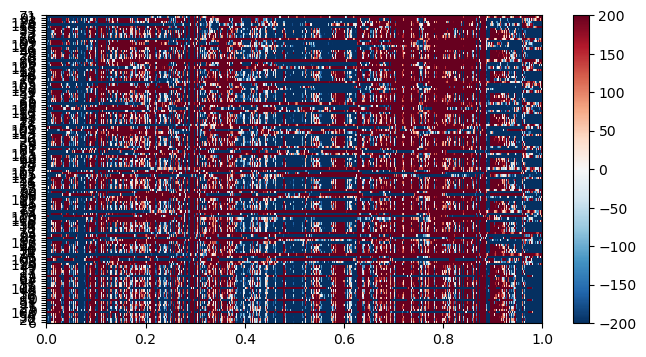

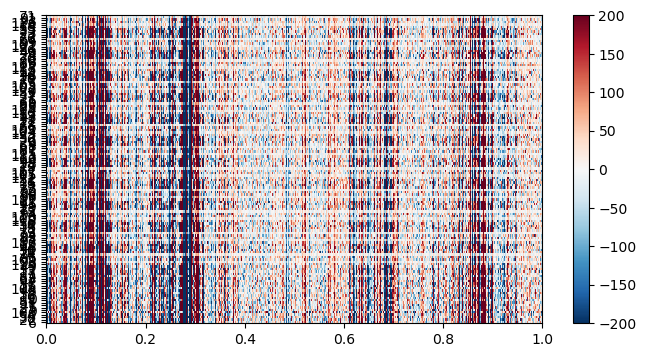

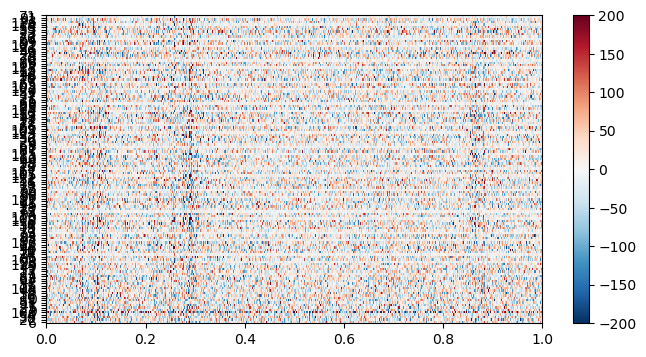

In [5]:
# Set probe and remove bad channels
# Use set_probegroup for ProbeGroup objects
# recording_raw = recording.set_probegroup(probe, group_mode='by_shank')
recording_raw = recording.set_probegroup(probegroup=probe, group_mode='by_probe')
recording_raw = recording_raw.remove_channels(remove_channel_ids=bad_ch_ids)

# Plot parameters
tmin = 0
twind = 1
segment_index = 0

# Plot raw traces
sw.plot_traces(
    recording_raw,
    channel_ids=recording_raw.get_channel_ids(),
    order_channel_by_depth=True,
    show_channel_ids=True,
    time_range=[tmin, tmin + twind],
    segment_index=segment_index,
    color_groups=False,
    figsize=(8, 4)
)

# Apply bandpass filter (500-8000 Hz)
recording_f = spre.bandpass_filter(recording_raw, freq_min=500, freq_max=8000)
sw.plot_traces(
    recording_f,
    channel_ids=recording_f.get_channel_ids(),
    order_channel_by_depth=True,
    show_channel_ids=True,
    time_range=[tmin, tmin + twind],
    segment_index=segment_index,
    color_groups=False,
    figsize=(8, 4)
)

# Apply common median reference (local)
recording_cmr = spre.common_reference(
    recording_f,
    reference='local',
    local_radius=[50, 200],
    operator='median'
)
sw.plot_traces(
    recording_cmr,
    channel_ids=recording_cmr.get_channel_ids(),
    order_channel_by_depth=True,
    show_channel_ids=True,
    time_range=[tmin, tmin + twind],
    segment_index=segment_index,
    color_groups=False,
    figsize=(8, 4)
)


# Initilizing and loadinng sorting result

In [6]:
from utils.data_io import load_rez, rezToPhy
sorting_folder_remote = glob.glob(basepath + '/Kilosort_*')[0]
sorting_folder = str(outputDir / (Path(sorting_folder_remote).name + "_curated"))
sorting_folder_orig = str(outputDir / (Path(sorting_folder_remote).name + "_original"))

# 1. Prepare Curated Folder (Copy and remove cluster_group.tsv)
if not os.path.exists(sorting_folder):
    print(f"Creating curated copy: {sorting_folder}")
    shutil.copytree(sorting_folder_remote, sorting_folder)
    tsv_path = Path(sorting_folder) / "cluster_group.tsv"
    if tsv_path.exists():
        tsv_path.unlink()
else:
    print(f"Curated folder already exists: {sorting_folder}")

# 2. Prepare Original Folder (copy rez.mat and reconstruct Phy files)
if not os.path.exists(sorting_folder_orig):
    print(f"Preparing original folder from rez.mat: {sorting_folder_orig}")
    os.makedirs(sorting_folder_orig, exist_ok=True)
    
    rez_path_remote = Path(sorting_folder_remote) / "rez.mat"
    if rez_path_remote.exists():
        # Copy only rez.mat
        shutil.copy2(rez_path_remote, Path(sorting_folder_orig) / "rez.mat")
        rez_local_path = str(Path(sorting_folder_orig) / "rez.mat")
        
        # Load rez and convert to Phy format using the function defined above
        print(f"Loading {rez_local_path} with h5py...")
        rez = load_rez(rez_local_path)
        
        print(f"Converting rez.mat to Phy files in {sorting_folder_orig}...")
        rezToPhy(rez, sorting_folder_orig)
    else:
        print(f"Error: rez.mat not found in {sorting_folder_remote}")
else:
    print(f"Original folder already exists: {sorting_folder_orig}")

Curated folder already exists: /local/workdir/ys2375/PreprocessPipeline/sorting_temp/day_32_20240430/Kilosort_2024-05-01_071006_curated
Original folder already exists: /local/workdir/ys2375/PreprocessPipeline/sorting_temp/day_32_20240430/Kilosort_2024-05-01_071006_original


In [13]:
sorting = se.read_phy(sorting_folder_orig)
sorting

PhySortingExtractor: 448 units - 1 segments - 20.0kHz

In [14]:
# sorting = se.read_phy(sorting_folder, exclude_cluster_groups=['noise', 'mua', 'unit_counts'])
# sorting

Number of units: 448
Total num spikes: 7,741,410
Average spikes per unit: 17,279.93


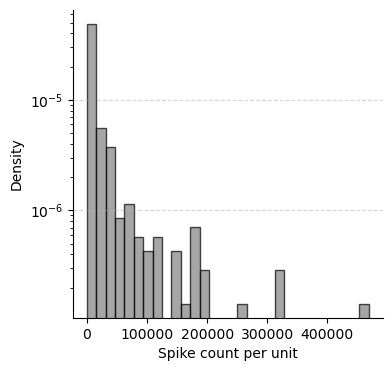

In [15]:
# Calculate spike counts for each unit
unit_counts = [len(sorting.get_unit_spike_train(u)) for u in sorting.unit_ids]
total_spikes = sum(unit_counts)
n_units = len(sorting.unit_ids)

print(f"Number of units: {n_units}")
print(f"Total num spikes: {total_spikes:,}")
print(f"Average spikes per unit: {total_spikes / n_units:,.2f}")

# Plot distribution of spike counts per unit (Normalized)
fig, ax = plt.subplots(figsize=(4, 4))
# density=True normalization: area under histogram sums to 1
ax.hist(unit_counts, bins=30, density=True, color='gray', edgecolor='black', alpha=0.7)
ax.set_yscale('log')
ax.set_xlabel("Spike count per unit")
ax.set_ylabel("Density")
ax.grid(axis='y', linestyle='--', alpha=0.5)
sns.despine()


# Post-hoc automatic curation

## Remove duplicate units

In [16]:
# Remove duplicated spikes within 0.5ms of same cluster
sorting_removed_duplicates = scur.remove_duplicated_spikes(sorting, censored_period_ms=0.5)

# Create sorting analyzer for quality assessment
sa_tmp = si.create_sorting_analyzer(
    sorting_removed_duplicates,
    recording_cmr,
    format="memory",
    sparse=False
)

# Remove redundant units (putative duplicates)
sorting_clean, redundancy_info = scur.remove_redundant_units(
    sa_tmp, 
    align=False, 
    duplicate_threshold=0.5,
    remove_strategy="max_spikes",
    extra_outputs=True,
)
print(f"Removed {len(redundancy_info)} redundant cluster combinations.")

Removed 62 redundant cluster combinations.


## Or without removal 

In [17]:
# sorting_clean = sorting.copy()

## Compute unit features 

In [18]:
# Create or load sorting analyzer with computed features
analyzer_folder = Path(Path(outputDir) / 'analyzer_cache')

if analyzer_folder.exists():
    analyzer = si.load_sorting_analyzer(folder=analyzer_folder)
    print("Loaded existing analyzer from disk.")
else:
    # Create new analyzer
    analyzer = si.create_sorting_analyzer(
        sorting=sorting_clean,
        recording=recording_cmr,
        format="binary_folder",   
        folder=analyzer_folder,
        overwrite=True,
        **job_kwargs,
    )

    # Compute all required features
    analyzer.compute(
        {
            "random_spikes": {"method": "all"}, 
            
            "waveforms": {},
            "templates": {},          
            "noise_levels": {},
            "spike_amplitudes": {},
            "principal_components": {"n_components": 5, "mode": "by_channel_local"}, 
            "template_metrics": {},       
            "template_similarity": {},    
            "correlograms": {},
            "spike_locations": {},
            "unit_locations": {},
        },
        **job_kwargs,  
    )
    analyzer = si.load_sorting_analyzer(folder=analyzer_folder)

Loaded existing analyzer from disk.


## Merge units

In [19]:
# Define merge criteria for clustering
steps_params = {
    "num_spikes": {           
        "min_spikes": 100,    
    },
    "correlogram": {
        "corr_diff_thresh": 0.25,
    },
    "template_similarity": {
        "template_diff_thresh": 0.25
    }
}

# Compute merge candidates based on similarity and correlograms
print("Computing merge candidates...")
merge_groups = scur.compute_merge_unit_groups(
    analyzer,                   
    preset="similarity_correlograms", 
    resolve_graph=True,               
    steps_params=steps_params    
)
print(f"Found {len(merge_groups)} groups to merge.")

Computing merge candidates...
Found 2 groups to merge.


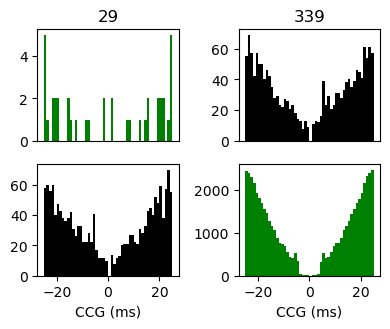

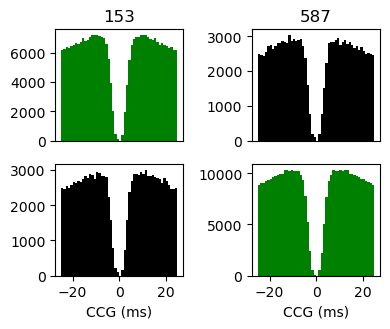

In [20]:
for i in range(len(merge_groups)):
    sw.plot_crosscorrelograms(
        sorting_analyzer_or_sorting=analyzer,
        unit_ids=merge_groups[i],            
        bin_ms=1,
        window_ms=25.0,
        figsize=(4, 3)
    )

In [21]:
# Check which unit groups can be safely merged
mergeable = analyzer.are_units_mergeable(
    merge_unit_groups=merge_groups,
    merging_mode="soft",
    sparsity_overlap=0.5
)

# Filter to only safely mergeable groups
merge_groups = [g for g, ok in mergeable.items() if ok]
nonmerge_groups = [g for g, ok in mergeable.items() if not ok]

if len(merge_groups)!=0:
    analyzer_merged = analyzer.merge_units(
        merge_unit_groups=merge_groups,
        merging_mode='soft', 
        censor_ms=0.5, 
        sparsity_overlap=0.5,
        return_new_unit_ids=False, 
        format="memory", 
        overwrite=True,       
        **job_kwargs     
)
    
else:
    analyzer_merged = analyzer
    print("No units to merge.")

## Split deviated waveforms

In [22]:
from utils.unit_split import autosplit_outliers_pca
sorting_split = autosplit_outliers_pca(
    analyzer_merged,
    # ---- distance (Mahalanobis) gate ----
    contamination=0.05,
    threshold_mode="adaptive_chi2",
    min_clean_frac=0.9,
    relax_factor=0.5,
    # ---- waveform similarity (Rescue) ----
    use_waveform_gate=True,        
    wf_threshold=0.2,          
    wf_template_max=1000,                        
    wf_n_chans=10,
    min_spikes=10,               
    wf_center="demean", 
    squeeze_all_outlier_to_new=True,
    return_details=False,
    verbose=True,
)

unit 0 (orig) -> unit 0 (clean, 177641 spikes) | split to unit 1 (outliers, 3010 spikes)
unit 1 (orig) -> unit 2 (clean, 1759 spikes) | split to unit 3 (outliers, 440 spikes)
unit 2 (orig) -> unit 4 (clean, 467887 spikes) | split to unit 5 (outliers, 100 spikes)
unit 3 (orig) -> unit 6 (clean, 286 spikes) | split to unit 7 (outliers, 105 spikes)
unit 4 (orig) -> unit 8 (clean, 26118 spikes) | split to unit 9 (outliers, 1699 spikes)
unit 5 (orig) -> unit 10 (clean, 118173 spikes) | split to unit 11 (outliers, 39 spikes)
unit 6 (orig) -> unit 12 (new): kept (109 spikes) | discarded 8 outliers (below min_spikes=10)
unit 7 (orig) -> unit 13 (clean, 144639 spikes) | split to unit 14 (outliers, 668 spikes)
unit 9 (orig) -> unit 15 (clean, 5121 spikes) | split to unit 16 (outliers, 97 spikes)
unit 10 (orig) -> unit 17 (new): kept (21238 spikes) | discarded 1 outliers (below min_spikes=10)
unit 11 (orig) -> unit 18 (clean, 708 spikes) | split to unit 19 (outliers, 198 spikes)
unit 12 (orig) ->

## Compute unit features again

In [23]:

analyzer_cache_processed = Path(outputDir) / "analyzer_cache_processed"
if analyzer_cache_processed.exists():
    try:
        shutil.rmtree(analyzer_cache_processed)
    except:
        pass
        
analyzer_split = si.create_sorting_analyzer(
    sorting=sorting_split,
    recording=recording_cmr,
    format="binary_folder",   
    folder=analyzer_cache_processed,
    overwrite=True,
    **job_kwargs,
)

# Compute all required features
analyzer_split.compute(
    {
        "random_spikes": {"method": "all"}, 
        "waveforms": {},
        "templates": {},          
        "noise_levels": {},
        "spike_amplitudes": {},
        "principal_components": {"n_components": 5, "mode": "by_channel_local"},
        "template_metrics": {},       
        "template_similarity": {},    
        "correlograms": {},
        "spike_locations": {},
        "unit_locations": {},
    },
    **job_kwargs,  
)


estimate_sparsity (workers: 506 processes):   0%|          | 0/24474 [00:00<?, ?it/s]

compute_waveforms (workers: 506 processes):   0%|          | 0/24474 [00:00<?, ?it/s]

noise_level (workers: 20 processes):   0%|          | 0/20 [00:00<?, ?it/s]

Fitting PCA:   0%|          | 0/524 [00:00<?, ?it/s]

Projecting waveforms:   0%|          | 0/524 [00:00<?, ?it/s]

/workdir/ys2375/miniforge3/envs/phy2/lib/python3.11/site-packages/spikeinterface/postprocessing/template_metrics.py:644: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  res = scipy.stats.linregress(times[peak_idx:max_idx], template_single[peak_idx:max_idx])


Compute : spike_amplitudes + spike_locations (workers: 506 processes):   0%|          | 0/24474 [00:00<?, ?it/…

## Compute unit metrics

In [24]:
# Get default quality metric parameters
qm_params = sqm.get_default_qm_params()

# Compute quality metrics for all units
metrics_df = sqm.compute_quality_metrics(
    analyzer_split,
    metric_names=['isi_violation', 'presence_ratio', 'snr', 'amplitude_median'],
    metric_params=qm_params,
    skip_pc_metrics=True,  # PCs are computed above
    n_jobs=n_jobs,
    progress_bar=True
)

## Export to phy and noise classification

In [25]:
# Export sorting results to Phy format for manual curation
phydir2 = Path(sorting_folder).parent / f"{Path(sorting_folder_remote).name}_spi"
export_to_phy(
    sorting_analyzer=analyzer_split,
    output_folder=phydir2,
    compute_pc_features=True,  
    compute_amplitudes=True,    
    copy_binary=False,           
    remove_if_exists=True,
    template_mode='average',
    add_quality_metrics=True,
    add_template_metrics=True,
    dtype=None,
    use_relative_path=True,
    verbose=True,
    **job_kwargs
)

# Fix params.py for Phy
params_file = Path(phydir2) / "params.py"

with open(params_file, 'r') as f:
    content = f.read()

# 1. Set dat_path to concatenated binary file
# Fix: convert Path object to string for concatenation or use / operator with string conversion
dat_files = glob.glob(str(outputDir / "*.dat"))
if dat_files:
    dat_relative_path = dat_files[0]
    content = content.replace("dat_path = None", f"dat_path = [r'{dat_relative_path}']")
else:
    print(f"Warning: No .dat files found in {outputDir}")

# 2. Set hp_filtered flag (data is already filtered)
new_hp_line = "hp_filtered = False"
if re.search(r"hp_filtered\s*=", content):
    content = re.sub(r"hp_filtered\s*=.*", new_hp_line, content)
else:
    content += f"\n{new_hp_line}"

# Write updated params back
with open(params_file, 'w') as f:
    f.write(content)

print(f"Fixed dat_path in {params_file}")
print(f"Set dat_path to: {dat_relative_path if dat_files else 'None'}")

extract PCs (workers: 506 processes):   0%|          | 0/24474 [00:00<?, ?it/s]

Run:
phy template-gui  /local/workdir/ys2375/PreprocessPipeline/sorting_temp/day_32_20240430/Kilosort_2024-05-01_071006_spi/params.py
Fixed dat_path in /local/workdir/ys2375/PreprocessPipeline/sorting_temp/day_32_20240430/Kilosort_2024-05-01_071006_spi/params.py
Set dat_path to: /local/workdir/ys2375/PreprocessPipeline/sorting_temp/day_32_20240430/day_32_20240430.dat


In [26]:
from utils.unit_classify import mark_noise_clusters_from_metrics
# Define quality thresholds for automatic noise cluster labeling
th = dict(
    isi_violations_ratio_gt=3,         # Mark as noise if ISI ratio > 3
    isi_violations_count_gt=50,        # AND violation count > 50
    presence_ratio_lt=0.1,             # OR presence ratio < 0.1
    snr_lt=0.3,                        # OR SNR < 0.3
    amplitude_median_lt=25.0,          # OR absolute amplitude < 25 µV
)

# Apply automatic noise labeling
updated = mark_noise_clusters_from_metrics(phydir2, metrics_df, th, backup=False)
n_noise = (updated["group"] == "noise").sum()
print(f"# of noise clusters: {n_noise}")

# of noise clusters: 350


Number of units: 524
Total num spikes: 7,718,006
Average spikes per unit: 14,729.02


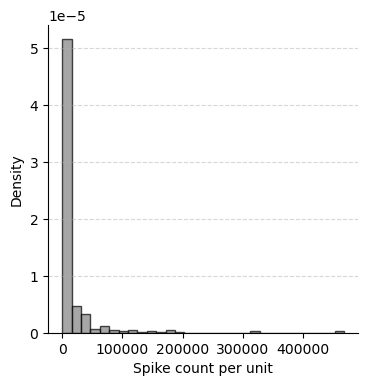

In [27]:
# Calculate spike counts for each unit
unit_counts = [len(sorting_split.get_unit_spike_train(u)) for u in sorting_split.unit_ids]
total_spikes = sum(unit_counts)
n_units = len(sorting_split.unit_ids)

print(f"Number of units: {n_units}")
print(f"Total num spikes: {total_spikes:,}")
print(f"Average spikes per unit: {total_spikes / n_units:,.2f}")

# Plot distribution of spike counts per unit (Normalized)
fig, ax = plt.subplots(figsize=(4, 4))
# density=True normalization: area under histogram sums to 1
ax.hist(unit_counts, bins=30, density=True, color='gray', edgecolor='black', alpha=0.7)
ax.set_xlabel("Spike count per unit")
ax.set_ylabel("Density")
ax.grid(axis='y', linestyle='--', alpha=0.5)
sns.despine()


In [28]:
phydir2_curated = phydir2.parent / f"{phydir2.name}_curated"

if phydir2.exists() and not phydir2_curated.exists():
    print(f"Copying {phydir2} to {phydir2_curated}...")
    shutil.copytree(phydir2, phydir2_curated)
    print("Done.")
elif phydir2_curated.exists():
    print(f"Directory already exists: {phydir2_curated}")
else:
    print(f"Source directory not found: {phydir2}")

Copying /local/workdir/ys2375/PreprocessPipeline/sorting_temp/day_32_20240430/Kilosort_2024-05-01_071006_spi to /local/workdir/ys2375/PreprocessPipeline/sorting_temp/day_32_20240430/Kilosort_2024-05-01_071006_spi_curated...
Done.


In [29]:
# import neuro_py as npy

# filename = phydir2_curated / 'cluster_info.tsv'
# npy.raw.spike_sorting_progress(filename)

In [30]:

# filename = phydir2_curated / 'phy.log'
# timestamps = npy.raw.phy_log_to_epocharray(filename)
# timestamps